In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.utils import resample
# Import Polynomial Regression library
from sklearn.preprocessing import PolynomialFeatures
# importing ploting libraries
import matplotlib.pyplot as plt 

import statsmodels.api   as sm
#importing seaborn for statistical plots
import seaborn as sns
%matplotlib inline
# Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
customer_data = pd.read_csv('BlackFriday.csv')

In [3]:
customer_data = customer_data.drop(columns=['Product_Category_2', 'Product_Category_3'], inplace=False,axis=1)

In [17]:
del customer

In [4]:
customer = customer_data.copy()

In [5]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 10 columns):
User_ID                       537577 non-null int64
Product_ID                    537577 non-null object
Gender                        537577 non-null object
Age                           537577 non-null object
Occupation                    537577 non-null int64
City_Category                 537577 non-null object
Stay_In_Current_City_Years    537577 non-null object
Marital_Status                537577 non-null int64
Product_Category_1            537577 non-null int64
Purchase                      537577 non-null int64
dtypes: int64(5), object(5)
memory usage: 41.0+ MB


## Feature Engineering

In [6]:
customer['User_ID'] = customer['User_ID'].astype('str', copy=False)
customer['Occupation'] = customer['Occupation'].astype('str', copy=False)
customer['Marital_Status'] =  customer['Marital_Status'].map({0 : 'UnMarried', 1: 'Married'})
customer['Product_Category_1'] = customer['Product_Category_1'].astype('str', copy=False)

# Setting all the categorical columns to type category
for col in set(customer.columns) - set(customer.describe().columns):
    customer[col] = customer[col].astype('category')
    

print(customer.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 10 columns):
User_ID                       537577 non-null category
Product_ID                    537577 non-null category
Gender                        537577 non-null category
Age                           537577 non-null category
Occupation                    537577 non-null category
City_Category                 537577 non-null category
Stay_In_Current_City_Years    537577 non-null category
Marital_Status                537577 non-null category
Product_Category_1            537577 non-null category
Purchase                      537577 non-null int64
dtypes: category(9), int64(1)
memory usage: 10.1 MB
None


## Ordinal Transformation of **AGE** and **Stay_In_Current_City_Years**

In [7]:
# Giving Age Numerical values
age_dict = {'0-17':10, '18-25':20, '26-35':30, '36-45':40, '46-50':50, '51-55':60, '55+':70}
customer["Age"] = customer["Age"].apply(lambda line: age_dict[line])

customer["Age"].value_counts()

30    214690
40    107499
20     97634
50     44526
60     37618
70     20903
10     14707
Name: Age, dtype: int64

In [8]:
stay_dict = {'0': 1, '1':2, '2':3, '3':4, '4+':5 }

customer['Stay_In_Current_City_Years'] = customer['Stay_In_Current_City_Years'].apply(lambda line: stay_dict[line])

In [9]:
customer["Age"] = customer["Age"].astype('int32', copy=False)

customer['Stay_In_Current_City_Years'] = customer['Stay_In_Current_City_Years'].astype('int32', copy=False)

# Frequency Count for each Category

In [10]:
# feature representing the count of each user
def getCountVar(compute_df, count_df, var_name):
    grouped_df = count_df.groupby(var_name)
    count_dict = {}
    for name, group in grouped_df:
        count_dict[name] = group.shape[0]

    count_list = []
    for index, row in compute_df.iterrows():
        name = row[var_name]
        count_list.append(count_dict.get(name, 0))
    return count_list



In [11]:
customer['ID_Counts'] = getCountVar(customer, customer, 'User_ID')
customer['Product_ID_Counts'] = getCountVar(customer, customer, 'Product_ID')
customer['Age_Counts'] = getCountVar(customer, customer, 'Age')
customer['Gender_Counts'] = getCountVar(customer, customer, 'Gender')
customer['Occupation_Counts'] = getCountVar(customer, customer, 'Occupation')
customer['City_Category_Counts'] = getCountVar(customer, customer, 'City_Category')
customer['Stay_In_Current_City_Years_Counts'] = getCountVar(customer, customer, 'Stay_In_Current_City_Years')
customer['Marital_Status_Years_Counts'] = getCountVar(customer, customer, 'Marital_Status')
customer['Product_Category_1_Counts'] = getCountVar(customer, customer, 'Product_Category_1')

In [26]:
customer['age2'] = customer['Age']**2

customer['stay2'] = customer['Stay_In_Current_City_Years']**2

## Polychotomization

In [12]:
# Setting all the categorical columns to type category
for col in set(customer.columns) - set(customer.describe().columns):
    customer[col] = customer[col].astype('category')
    

print(customer.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 19 columns):
User_ID                              537577 non-null category
Product_ID                           537577 non-null category
Gender                               537577 non-null category
Age                                  537577 non-null int32
Occupation                           537577 non-null category
City_Category                        537577 non-null category
Stay_In_Current_City_Years           537577 non-null int32
Marital_Status                       537577 non-null category
Product_Category_1                   537577 non-null category
Purchase                             537577 non-null int64
ID_Counts                            537577 non-null int64
Product_ID_Counts                    537577 non-null int64
Age_Counts                           537577 non-null int64
Gender_Counts                        537577 non-null int64
Occupation_Counts                    53757

## Dropping User ID and Product ID

In [13]:
customer = customer.drop(columns=['User_ID','Product_ID'], inplace=False, axis=1)

In [29]:
customer = customer.drop(columns=['age2','stay2'], inplace=False, axis=1)

In [14]:
features = list(customer.columns)
features.remove('Purchase')
features

['Gender',
 'Age',
 'Occupation',
 'City_Category',
 'Stay_In_Current_City_Years',
 'Marital_Status',
 'Product_Category_1',
 'ID_Counts',
 'Product_ID_Counts',
 'Age_Counts',
 'Gender_Counts',
 'Occupation_Counts',
 'City_Category_Counts',
 'Stay_In_Current_City_Years_Counts',
 'Marital_Status_Years_Counts',
 'Product_Category_1_Counts']

In [15]:
customer_polychot = pd.get_dummies(data=customer[features], drop_first=True)

In [16]:
len(customer_polychot.columns)

52

## Modeling

In [32]:
x = customer_polychot.copy()
y = customer_data['Purchase'].copy()

In [33]:
## Adjusted R^2
def AdjRsquare(model, x, y):
    Rsquare = model.score(x, y)
    NoData = len(y)
    p = x.shape[1]
    tempRsquare = 1 - (1-Rsquare)*(NoData - 1
                                  )/(NoData - p - 1)
    return tempRsquare

In [34]:
## Combine all the steps to test the model performance
def linRegcheckModelPerformance(x, y):
    model = LinearRegression()
    # Covert data into train and test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state = 666, shuffle= True)
    # Build model with train data set
    model.fit(x_train, y_train)
    # Train accuracies
    trainR2 = model.score(x_train, y_train)
    predictedPurchaseTrain= model.predict(x_train)
    TrainMse = metrics.mean_squared_error(y_train, predictedPurchaseTrain)
    trainRmse = np.sqrt(TrainMse)
    trainRmsePct = trainRmse/np.mean(np.mean(np.array(y_train)))*100
    trainAdjR2 = AdjRsquare(model, x_train, y_train)
    trainAccuracies = [trainRmse, trainRmsePct, trainR2, trainAdjR2]
    # Test accuracies
    testR2 = model.score(x_test, y_test)
    predictedPurchaseTest = model.predict(x_test)
    TestMse = metrics.mean_squared_error( y_test, predictedPurchaseTest)
    testRmse = np.sqrt(TestMse)
    testRmsePct = testRmse/np.mean(np.mean(np.array(y_test)))*100
    testAdjR2 = AdjRsquare(model, x_test, y_test)
    testAccuracies = [testRmse, testRmsePct, testR2, testAdjR2]
    # Create dataframe for results
    resultsDf = pd.DataFrame(index = ["rmse", "rmsePct", "r2", "adjR2"])
    resultsDf['trainAccuracy'] = trainAccuracies
    resultsDf['testAccuracy'] = testAccuracies
    return ( round(resultsDf, 2))

In [35]:
linRegcheckModelPerformance(x,y)

,trainAccuracy,testAccuracy
rmse,2904.17,2905.23
rmsePct,31.13,31.08
r2,0.66,0.66
adjR2,0.66,0.66


# Regularization

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state = 666, shuffle= True)

In [38]:
## Combine all the steps to test the model performance
def LassoModelPerformance(model,x, y):
    
    # Covert data into train and test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state = 666, shuffle= True)
    # Build model with train data set
    model.fit(x_train, y_train)
    # Train accuracies
    trainR2 = model.score(x_train, y_train)
    predictedPurchaseTrain= model.predict(x_train)
    TrainMse = metrics.mean_squared_error(y_train, predictedPurchaseTrain)
    trainRmse = np.sqrt(TrainMse)
    trainRmsePct = trainRmse/np.mean(np.mean(np.array(y_train)))*100
    trainAdjR2 = AdjRsquare(model, x_train, y_train)
    trainAccuracies = [trainRmse, trainRmsePct, trainR2, trainAdjR2]
    # Test accuracies
    testR2 = model.score(x_test, y_test)
    predictedPurchaseTest = model.predict(x_test)
    TestMse = metrics.mean_squared_error( y_test, predictedPurchaseTest)
    testRmse = np.sqrt(TestMse)
    testRmsePct = testRmse/np.mean(np.mean(np.array(y_test)))*100
    testAdjR2 = AdjRsquare(model, x_test, y_test)
    testAccuracies = [testRmse, testRmsePct, testR2, testAdjR2]
    # Create dataframe for results
    resultsDf = pd.DataFrame(index = ["rmse", "rmsePct", "r2", "adjR2"])
    resultsDf['trainAccuracy'] = trainAccuracies
    resultsDf['testAccuracy'] = testAccuracies
    return ( round(resultsDf, 2))

In [37]:
lasso1 = Lasso(alpha=0.01,tol=0.000001, random_state=666)
lasso2 = Lasso(alpha=0.5,tol=0.000001, random_state=666)
lasso3 = Lasso(alpha=1,tol=0.000001, random_state=666)
lasso4 = Lasso(alpha=10,tol=0.000001,random_state=666)
lasso5 = Lasso(alpha=0.1,tol=0.000001, random_state=666)  ## Best Model
lasso6 = Lasso(alpha=25, tol=0.000001, random_state=666)

## Transforming the Response

In [54]:
#x = customer_polychot.copy()
#y = customer_data['Purchase']
y_sqrt = np.sqrt(y.copy())
y_inv_sqrt = 1/(np.sqrt(y.copy()))
y_log = np.log(y.copy())

In [151]:
x_train, x_test, y_train, y_test = train_test_split(x, y_sqrt, test_size=0.2,random_state = 666, shuffle= True)

lasso5 = lasso5.fit(x_train, y_train)

y_pred = lasso5.predict(x_test)
y_pred2 = y_pred**2
y_real = y_test**2
mse = metrics.mean_squared_error(y_real, y_pred2)
rmse = np.sqrt(mse)
rmse

2988.1577254512113

In [155]:
del x_train, x_test, y_train, y_test, y_pred, y_pred2,y_real, mse,rmse

In [157]:
x_train, x_test, y_train, y_test = train_test_split(x, y_inv_sqrt, test_size=0.2,random_state = 666, shuffle= True)

lasso5 = lasso5.fit(x_train, y_train)

y_pred = lasso5.predict(x_test)
y_pred2 = 1/(y_pred**2)
y_real = 1/(y_test**2)
mse = metrics.mean_squared_error(y_real, y_pred2)
rmse = np.sqrt(mse)
rmse

5326.849536084145

NameError: name 'x_train' is not defined

In [154]:
x_train, x_test, y_train, y_test = train_test_split(x, y_log, test_size=0.2,random_state = 666, shuffle= True)

lasso5 = lasso5.fit(x_train, y_train)

y_pred = lasso5.predict(x_test)
y_pred2 = np.exp(y_pred)
y_real = np.exp(y_test)
mse = metrics.mean_squared_error(y_real, y_pred2)
rmse = np.sqrt(mse)
rmse

4912.579273474293

**Square Root Transformation of Response gives the lowest RMSE**    
**But the RMSE is not higher then the Non-Transformative Model**

## Variable Importance

In [191]:
# Covert data into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state = 666, shuffle= True)
# Build model with train data set
lasso6.fit(x_train, y_train)
    # Train accuracies
trainR2 = lasso6.score(x_train, y_train)
predictedPurchaseTrain= lasso6.predict(x_train)
TrainMse = metrics.mean_squared_error(y_train, predictedPurchaseTrain)
trainRmse = np.sqrt(TrainMse)
trainRmsePct = trainRmse/np.mean(np.mean(np.array(y_train)))*100
trainAdjR2 = AdjRsquare(lasso6, x_train, y_train)
trainAccuracies = [trainRmse, trainRmsePct, trainR2, trainAdjR2]
    # Test accuracies
testR2 = lasso6.score(x_test, y_test)
predictedPurchaseTest = lasso6.predict(x_test)
TestMse = metrics.mean_squared_error( y_test, predictedPurchaseTest)
testRmse = np.sqrt(TestMse)
testRmsePct = testRmse/np.mean(np.mean(np.array(y_test)))*100
testAdjR2 = AdjRsquare(lasso6, x_test, y_test)
testAccuracies = [testRmse, testRmsePct, testR2, testAdjR2]
    # Create dataframe for results
resultsDf = pd.DataFrame(index = ["rmse", "rmsePct", "r2", "adjR2"])
resultsDf['trainAccuracy'] = trainAccuracies
resultsDf['testAccuracy'] = testAccuracies
print ( round(resultsDf, 2))

         trainAccuracy  testAccuracy
rmse           3015.84       3017.56
rmsePct          32.33         32.28
r2                0.63          0.63
adjR2             0.63          0.63


In [159]:
# Covert data into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state = 666, shuffle= True)
# Build model with train data set
lasso5.fit(x_train, y_train)
    # Train accuracies
trainR2 = lasso5.score(x_train, y_train)
predictedPurchaseTrain= lasso5.predict(x_train)
TrainMse = metrics.mean_squared_error(y_train, predictedPurchaseTrain)
trainRmse = np.sqrt(TrainMse)
trainRmsePct = trainRmse/np.mean(np.mean(np.array(y_train)))*100
trainAdjR2 = AdjRsquare(lasso5, x_train, y_train)
trainAccuracies = [trainRmse, trainRmsePct, trainR2, trainAdjR2]
    # Test accuracies
testR2 = lasso5.score(x_test, y_test)
predictedPurchaseTest = lasso5.predict(x_test)
TestMse = metrics.mean_squared_error( y_test, predictedPurchaseTest)
testRmse = np.sqrt(TestMse)
testRmsePct = testRmse/np.mean(np.mean(np.array(y_test)))*100
testAdjR2 = AdjRsquare(lasso5, x_test, y_test)
testAccuracies = [testRmse, testRmsePct, testR2, testAdjR2]
    # Create dataframe for results
resultsDf = pd.DataFrame(index = ["rmse", "rmsePct", "r2", "adjR2"])
resultsDf['trainAccuracy'] = trainAccuracies
resultsDf['testAccuracy'] = testAccuracies
print ( round(resultsDf, 2))

         trainAccuracy  testAccuracy
rmse           2904.18       2905.23
rmsePct          31.13         31.08
r2                0.66          0.66
adjR2             0.66          0.66


**Going With Lasso4 as it reduces the variables the most without affecting the Test Metrics**

In [38]:
# Covert data into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state = 666, shuffle= True)
# Build model with train data set
lasso4.fit(x_train, y_train)
    # Train accuracies
trainR2 = lasso4.score(x_train, y_train)
predictedPurchaseTrain= lasso4.predict(x_train)
TrainMse = metrics.mean_squared_error(y_train, predictedPurchaseTrain)
trainRmse = np.sqrt(TrainMse)
trainRmsePct = trainRmse/np.mean(np.mean(np.array(y_train)))*100
trainAdjR2 = AdjRsquare(lasso4, x_train, y_train)
trainAccuracies = [trainRmse, trainRmsePct, trainR2, trainAdjR2]
    # Test accuracies
testR2 = lasso4.score(x_test, y_test)
predictedPurchaseTest = lasso4.predict(x_test)
TestMse = metrics.mean_squared_error( y_test, predictedPurchaseTest)
testRmse = np.sqrt(TestMse)
testRmsePct = testRmse/np.mean(np.mean(np.array(y_test)))*100
testAdjR2 = AdjRsquare(lasso4, x_test, y_test)
testAccuracies = [testRmse, testRmsePct, testR2, testAdjR2]
    # Create dataframe for results
resultsDf = pd.DataFrame(index = ["rmse", "rmsePct", "r2", "adjR2"])
resultsDf['trainAccuracy'] = trainAccuracies
resultsDf['testAccuracy'] = testAccuracies
print ( round(resultsDf, 2))

         trainAccuracy  testAccuracy
rmse           2928.48       2930.12
rmsePct          31.39         31.35
r2                0.65          0.66
adjR2             0.65          0.66


In [39]:
variables = pd.DataFrame( columns=['Predictor','Value'])

In [40]:
variables['Value'] = lasso4.coef_
variables['Predictor'] = x.columns

In [41]:
regularized_vars = variables[variables['Value'] != 0].copy()

In [42]:
imp_predictors = regularized_vars.sort_values(by='Value',ascending=False)

In [43]:
imp_predictors[(imp_predictors['Value']> 1) |(imp_predictors['Value']< -1)]

,Predictor,Value
35,Product_Category_1_10,7234.197943
49,Product_Category_1_7,4582.929035
48,Product_Category_1_6,3969.074914
41,Product_Category_1_16,3204.810983
40,Product_Category_1_15,3022.698769
33,City_Category_C,57.890670
0,Age,9.877390
3,Product_ID_Counts,2.474089
1,Stay_In_Current_City_Years,1.892875
12,Occupation_1,-22.356385


In [197]:
#lasso1.fit(x_train, y_train)
#lasso2.fit(x_train, y_train)
#lasso3.fit(x_train, y_train)
lasso4.fit(x_train, y_train)

Lasso(alpha=10, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=666,
   selection='cyclic', tol=1e-06, warm_start=False)

## Predictor Counts

In [44]:
#len(lasso1.coef_[lasso1.coef_ != 0])
#len(lasso2.coef_[lasso2.coef_ != 0])
#len(lasso3.coef_[lasso3.coef_ != 0])
len(lasso4.coef_[lasso4.coef_ != 0])

26

In [193]:
len(lasso6.coef_[lasso6.coef_ != 0])

23

# Statistical Learning

In [45]:
sns.set(style="whitegrid")
import statsmodels.api as sm

In [46]:
vals = list(imp_predictors[(imp_predictors['Value']> 1) |(imp_predictors['Value']< -1)]['Predictor'].values)

In [47]:
X = sm.add_constant(x[vals])
Y = y

In [48]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,random_state = 666, shuffle= True)

In [49]:
model = sm.OLS(y_train, x_train).fit()

In [51]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Purchase   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                 3.935e+04
Date:                Sun, 06 Jan 2019   Prob (F-statistic):               0.00
Time:                        17:40:07   Log-Likelihood:            -3.5381e+06
No. Observations:              376303   AIC:                         7.076e+06
Df Residuals:                  376284   BIC:                         7.076e+06
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       1.134e+04     20.082    564.769      0.000    1.13e+04    1.14e+04
Product_Category_1_10       6534.2674     50.434    129.561      0.000    6435.419    6633.116
Product_Category_1_7        4267.2267     58.652     72.755      0.000    4152.270    4382.183
Product_Category_1_6        2659.5272     26.192    101.541      0.000    2608.192    2710.862
Product_Category_1_16       2026.6088     36.722     55.187      0.000    1954.634    2098.583
Product_Category_1_15       2123.6187     45.426     46.749      0.000    2034.586    2212.651
City_Category_C              283.9126     10.471     27.114      0.000     263.389     304.436
Age                           10.0330      0.359     27.939      0.000       9.329      10.737
Product_ID_Counts              2.5978      0.014    185.461      0.000       2.570       2.625
Stay_In_Current_City_Years     7.8901      3.708      2.128      0.033       0.622      15.158
Occupation_1                -162.6174     17.166     -9.473      0.000    -196.262    -128.973
Product_Category_1_3       -2811.2377     26.454   -106.270      0.000   -2863.086   -2759.389
Product_Category_1_8       -5218.7197     13.907   -375.253      0.000   -5245.977   -5191.462
Product_Category_1_18      -9453.6809     64.223   -147.202      0.000   -9579.555   -9327.806
Product_Category_1_11      -7742.6858     24.644   -314.179      0.000   -7790.988   -7694.384
Product_Category_1_5       -6633.2756     12.698   -522.406      0.000   -6658.162   -6608.389
Product_Category_1_12      -1.122e+04     56.755   -197.758      0.000   -1.13e+04   -1.11e+04
Product_Category_1_4       -1.045e+04     33.805   -309.155      0.000   -1.05e+04   -1.04e+04
Product_Category_1_13      -1.191e+04     48.513   -245.426      0.000    -1.2e+04   -1.18e+04
==============================================================================
Omnibus:                    25738.420   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40241.900
Skew:                          -0.554   Prob(JB):                         0.00
Kurtosis:                       4.157   Cond. No.                     7.72e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Residuals

In [91]:
t1 = np.random.randint(0,len(test_pred),1000)  # Returns  5 rand integers between 20 & 49(50 is excluded)
t2 = np.random.randint(0,len(test_pred),5000)
t3 = np.random.randint(0,len(test_pred),10000)
t4 = np.random.randint(0,len(test_pred),50000)
t5 = np.random.randint(0,len(test_pred),500)

In [52]:
test_pred = model.predict(x_test)
residuals = y_test - test_pred

In [73]:
test = np.array(test_pred)
resids = np.array(residuals.copy())

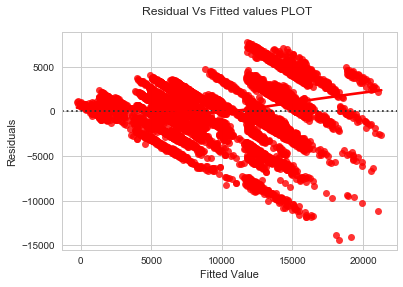

In [82]:
# Plot the residuals after fitting a linear model
ax = sns.residplot(test[t3], resids[t3], lowess = True, color = "r")
ax.set(xlabel='Fitted Value', ylabel='Residuals', title = 'Residual Vs Fitted values PLOT \n')
plt.show()

In [86]:
test_pred2 = model.predict(x_test)
residLog = np.log(y_test) - np.log(test_pred)

In [87]:
testLog = np.array(test_pred2)
residLog = np.array(residLog.copy())

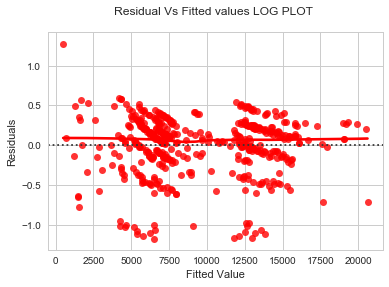

In [93]:
# Log transformation
# Plot the residuals after fitting a linear model
ax = sns.residplot(testLog[t5], residLog[t5], lowess = True, color = "r")
ax.set(xlabel='Fitted Value', ylabel='Residuals', title = 'Residual Vs Fitted values LOG PLOT \n')
plt.show()

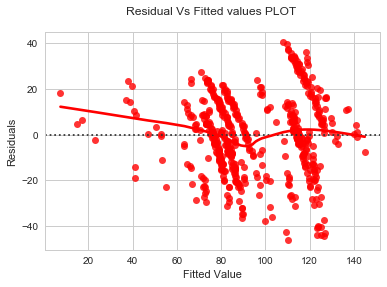

In [85]:
# sqrt Transformation
# Plot the residuals after fitting a linear model
ax = sns.residplot(sqrtPred[t1], sqrtResi[t1], lowess = True, color = "r")
ax.set(xlabel='Fitted Value', ylabel='Residuals', title = 'Residual Vs Fitted values PLOT \n')
plt.show()

## Histogram of Residuals

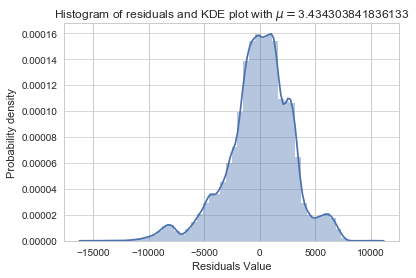

In [271]:
sns.set(style="whitegrid")
sns.distplot(residuals)

plt.grid(axis = 'y', alpha = 0.75)
plt.xlabel('Residuals Value')
plt.ylabel('Probability density') # It is the probability per unit on the x-axis.

mean     =   residuals.mean()

plt.title('Histogram of residuals and KDE plot with ' + r'$\mu = $' + str(np.round(mean,17)))
plt.show()

In [276]:
from statsmodels.graphics.gofplots import ProbPlot

model_fit_y               = model.fittedvalues
model_residuals           = model.resid # Model residuals


### Normalized residuals
model_normal_residuals    = model.get_influence().resid_studentized_internal 

### absolute squared normalized residuals
model_normal_residuals_abs_sqrt  = np.sqrt(np.abs(model_normal_residuals)) 

### absolute residuals
model_abs_resid                  = np.abs(model_residuals) 

### leverage 
model_leverage                   = model.get_influence().hat_matrix_diag 

### Cook's distance
model_cooks                      = model.get_influence().cooks_distance[0] 

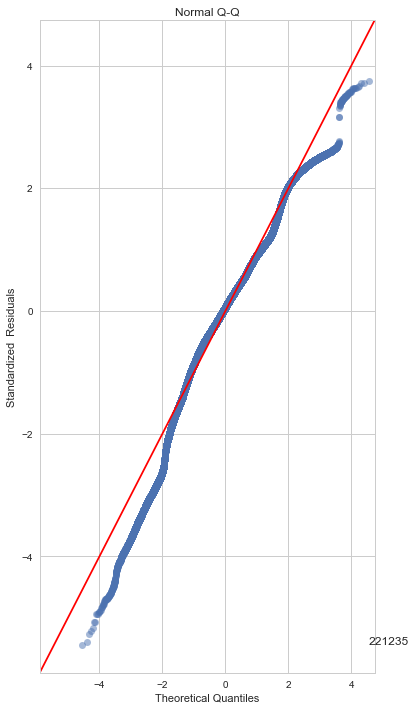

In [277]:
QQ         = ProbPlot(model_normal_residuals)
plot_lm_2  = QQ.qqplot(line = '45', alpha = 0.5, color = '#4C72B0', lw = 1.5)

plot_lm_2.set_figheight(8)
plot_lm_2.set_figheight(12)

plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized  Residuals')

# annotations

abs_norm_resid       = np.flip(np.argsort(np.abs(model_normal_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]

for r, i in enumerate(abs_norm_resid_top_3):
     plot_lm_2.axes[0].annotate(i, 
            xy = (np.flip(QQ.theoretical_quantiles, 0)[r],
            model_normal_residuals[i]));
     plt.show()


In [56]:
from statsmodels.graphics.regressionplots import *


In [57]:
plot_lm_4  = plt.figure(4)
plot_lm_4.set_figheight(18)
plot_lm_4.set_figheight(20)
plot_leverage_resid2(model)
#influence_plot(model)
plt.show()

<Figure size 432x1440 with 0 Axes>

KeyboardInterrupt: 